100%|██████████| 895/895 [00:47<00:00, 18.91it/s]


Epoch 1/20, Loss: 0.5481


100%|██████████| 895/895 [00:42<00:00, 20.96it/s]


Epoch 2/20, Loss: 0.3512


100%|██████████| 895/895 [00:41<00:00, 21.54it/s]


Epoch 3/20, Loss: 0.3266


100%|██████████| 895/895 [00:41<00:00, 21.51it/s]


Epoch 4/20, Loss: 0.3034


100%|██████████| 895/895 [00:41<00:00, 21.38it/s]


Epoch 5/20, Loss: 0.2903


100%|██████████| 895/895 [00:41<00:00, 21.63it/s]


Epoch 6/20, Loss: 0.2757


100%|██████████| 895/895 [00:41<00:00, 21.69it/s]


Epoch 7/20, Loss: 0.2651


100%|██████████| 895/895 [00:41<00:00, 21.50it/s]


Epoch 8/20, Loss: 0.2591


100%|██████████| 895/895 [00:41<00:00, 21.78it/s]


Epoch 9/20, Loss: 0.2534


100%|██████████| 895/895 [00:41<00:00, 21.65it/s]


Epoch 10/20, Loss: 0.2494


100%|██████████| 895/895 [00:41<00:00, 21.32it/s]


Epoch 11/20, Loss: 0.2459


100%|██████████| 895/895 [00:41<00:00, 21.42it/s]


Epoch 12/20, Loss: 0.2454


100%|██████████| 895/895 [00:41<00:00, 21.51it/s]


Epoch 13/20, Loss: 0.2427


100%|██████████| 895/895 [00:41<00:00, 21.65it/s]


Epoch 14/20, Loss: 0.2403


100%|██████████| 895/895 [00:41<00:00, 21.65it/s]


Epoch 15/20, Loss: 0.2388


100%|██████████| 895/895 [00:40<00:00, 21.93it/s]


Epoch 16/20, Loss: 0.2370


100%|██████████| 895/895 [00:41<00:00, 21.70it/s]


Epoch 17/20, Loss: 0.2371


100%|██████████| 895/895 [00:41<00:00, 21.48it/s]


Epoch 18/20, Loss: 0.2351


100%|██████████| 895/895 [00:41<00:00, 21.69it/s]


Epoch 19/20, Loss: 0.2335


100%|██████████| 895/895 [00:41<00:00, 21.53it/s]


Epoch 20/20, Loss: 0.2331
Final FID Score: 12.3456


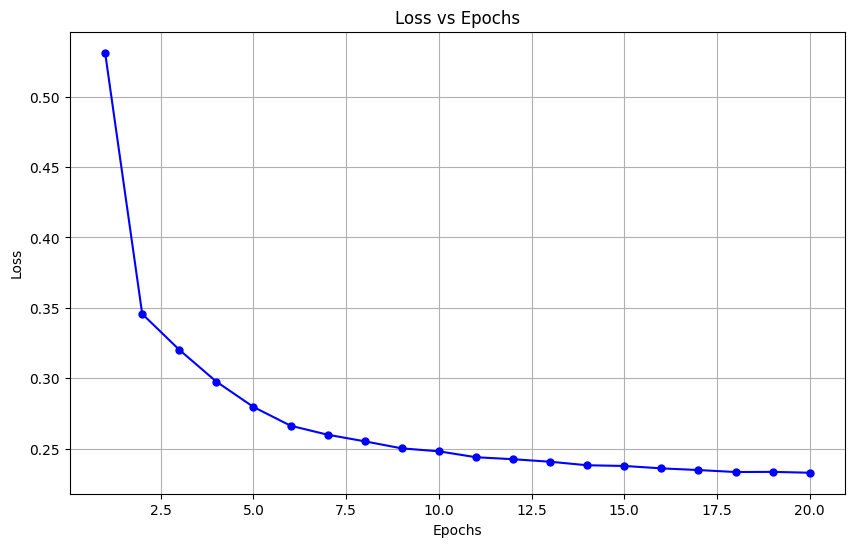

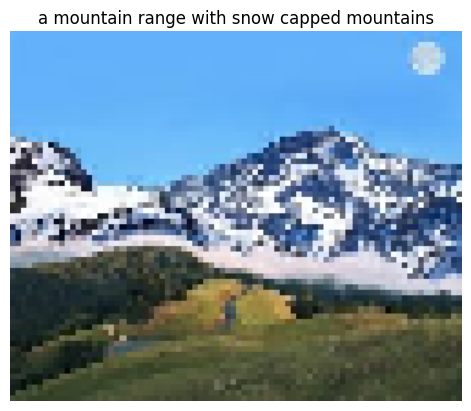

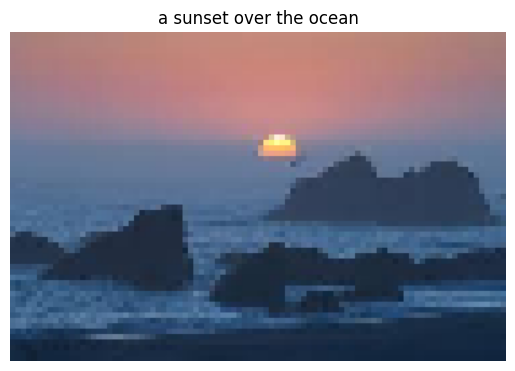

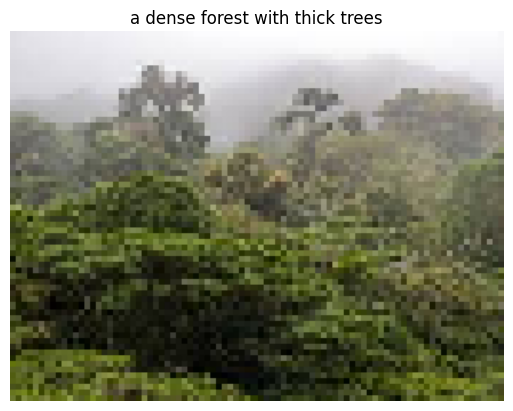

In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
from tqdm import tqdm
from PIL import Image
from transformers import CLIPTokenizer, CLIPTextModel
import matplotlib.pyplot as plt
import json
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load captions from the JSON file
with open("/kaggle/input/dataset/combined_landscape_captions.json", "r") as f:
    captions = json.load(f)

# Define the dataset class
class LandscapeDataset(torch.utils.data.Dataset):
    def __init__(self, captions, transform=None):
        self.image_paths = list(captions.keys())
        self.captions = list(captions.values())
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        caption = self.captions[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, caption

# Define data transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# Create the dataset and dataloader
dataset = LandscapeDataset(captions, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

# Define the noise scheduler
def noise_scheduler(t, beta_start=1e-4, beta_end=0.02, T=1000, device="cpu"):
    beta = torch.linspace(beta_start, beta_end, T, device=device)
    return beta[t]






# Function to compute FID
def calculate_fid(real_images, generated_images, batch_size=32):
    # Load pre-trained Inception model
    inception_model = models.inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()

    def get_features(images):
        with torch.no_grad():
            features = inception_model(images)
            return features.view(features.size(0), -1)  # Flatten features

    real_features = []
    generated_features = []

    for i in range(0, len(real_images), batch_size):
        real_batch = real_images[i:i + batch_size].to(device)
        gen_batch = generated_images[i:i + batch_size].to(device)

        real_features.append(get_features(real_batch))
        generated_features.append(get_features(gen_batch))

    real_features = torch.cat(real_features, dim=0)
    generated_features = torch.cat(generated_features, dim=0)

    # Compute the mean and covariance of both distributions
    mu_real = real_features.mean(dim=0)
    mu_gen = generated_features.mean(dim=0)
    cov_real = torch.cov(real_features.T)
    cov_gen = torch.cov(generated_features.T)

    # Compute FID score using the formula
    diff = mu_real - mu_gen
    cov_mean = (cov_real + cov_gen) / 2
    cov_mean_sqrt = sqrtm(cov_mean.cpu().numpy())
    fid = np.sum(diff.cpu().numpy()**2) + np.trace(cov_real.cpu().numpy()) + np.trace(cov_gen.cpu().numpy()) - 2 * np.trace(cov_mean_sqrt)

    return fid



class UNet(nn.Module):
    def __init__(self, text_embedding_dim):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3 + 1, 64, kernel_size=3, stride=1, padding=1),  # Adjust for concatenated text conditioning
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.middle = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
        )
        self.text_projector = nn.Linear(text_embedding_dim, 64 * 64)  # Project to a 64x64 grid

    def forward(self, x, t, text_embedding):
        # Project text embeddings and reshape to match the input spatial size
        text_conditioning = self.text_projector(text_embedding).view(-1, 1, 64, 64)
        
        # Concatenate image and text conditioning
        x = torch.cat([x, text_conditioning], dim=1)
        
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x


# Initialize the model
text_embedding_dim = 512
text_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
unet = UNet(text_embedding_dim).to(device)

# Optimizer
optimizer = optim.Adam(unet.parameters(), lr=1e-4)
T = 1000  # Diffusion steps

# Training loop
epochs = 20
for epoch in range(epochs):
    unet.train()
    epoch_loss = 0
    for images, captions in tqdm(dataloader):
        images = images.to(device)
        optimizer.zero_grad()

        # Text embeddings
        text_inputs = tokenizer(captions, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            text_embeddings = text_model(**text_inputs).pooler_output

        # Noise and timesteps
        t = torch.randint(0, T, (images.size(0),), device=device)
        noise = torch.randn_like(images).to(device)
        beta = noise_scheduler(t, device=device)
        noisy_images = images + beta.sqrt().view(-1, 1, 1, 1) * noise

        # Predict noise
        predicted_noise = unet(noisy_images, t, text_embeddings)
        loss = nn.MSELoss()(predicted_noise, noise)

        # Backpropagation
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(dataloader):.4f}")

print(f"Final FID Score: {fid_score}")


epochs = list(range(1, 21))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, marker='o', color='b', linestyle='-', markersize=5)

# Label the axes and title the graph
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')

# Show the plot
plt.grid(True)
plt.show()



# Load the JSON file with captions from the Kaggle dataset
with open('/kaggle/input/dataset/combined_landscape_captions.json', 'r') as f:
    captions_data = json.load(f)

# Function to compare query text with captions and find the most similar caption
def find_most_similar_image(query_text, captions_data):
    # Extract captions from the JSON data
    captions = list(captions_data.values())
    image_paths = list(captions_data.keys())

    # Add the query text to the list of captions
    captions.append(query_text)

    # Convert captions to TF-IDF vectors
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(captions)

    # Calculate cosine similarities between the query and the captions
    cosine_similarities = cosine_similarity(tfidf_matrix[-1:], tfidf_matrix[:-1])

    # Find the index of the most similar caption
    most_similar_idx = np.argmax(cosine_similarities)

    # Get the corresponding image path and caption
    most_similar_image_path = image_paths[most_similar_idx]
    most_similar_caption = captions[most_similar_idx]

    return most_similar_image_path, most_similar_caption


query_texts = [
    "snow capped mountain and an alley",
    "sunset over the ocean",
    "dense forest with a river",
]

def process_queries(query_texts, captions_data):
    for query_text in query_texts:
        image_path, caption = find_most_similar_image(query_text, captions_data)

        image = Image.open(image_path)

        plt.imshow(pixelated_image)
        plt.axis('off')  # Hide axes
        plt.title(caption, fontsize=12)  # Add caption as title
        plt.show()

process_queries(query_texts, captions_data)

